In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer, RobustScaler


In [2]:
# Load the cleaned data
exoplanet_data = pd.read_csv('Remove_Correlated_Columns.csv')

# Identify the planet name column
planet_name_column = 'Planet Name' 

# Select numerical columns and keep the planet name
numerical_data = exoplanet_data.select_dtypes(include=['float64', 'int64'])
planet_names = exoplanet_data[planet_name_column]


In [3]:
# Calculate initial skewness
initial_skewness = numerical_data.skew()
print("Initial Skewness of each feature:")
print(initial_skewness)


Initial Skewness of each feature:
Orbital Period                          43.510162
Orbital Eccentricity                     2.962593
Orbital Inclination                     -2.555883
Planet Radius (Earth Radii)              1.360525
Planet Density                          55.899114
Equilibrium Temperature                  1.585463
Insolation Flux                          9.597684
Transit Depth                           54.030289
Transit Duration                         4.451750
Star Mass                                7.163642
Effective Temperature                   15.690582
Star Luminosity                         -0.452662
Star Radius                             14.078009
Star Age                                 1.398785
Metallicity                             -0.660452
Distance                                 4.148003
Parallax                                 8.034394
Discovery Year                          -0.861880
Number of Photometric Measurements      17.579140
Number of RV Mea

In [4]:
# Function to cap outliers
def cap_outliers(df, lower_percentile=0.01, upper_percentile=0.99):
    capped_df = df.copy()
    for column in capped_df.columns:
        lower_bound = capped_df[column].quantile(lower_percentile)
        upper_bound = capped_df[column].quantile(upper_percentile)
        capped_df[column] = np.clip(capped_df[column], lower_bound, upper_bound)
    return capped_df


In [5]:
# Cap outliers
capped_data = cap_outliers(numerical_data)


In [6]:
# Function to transform data while preserving original columns if skewness worsens
def transform_data_preserve(df, initial_skewness):
    transformed_df = df.copy()  # Create a copy to preserve original data
    scaler = RobustScaler()  # Use RobustScaler
    scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)  # Scale the data
    
    for column in scaled_df.columns:
        if abs(initial_skewness[column]) > 0.5:  # Check if skewness is significant
            try:
                pt = PowerTransformer(method='yeo-johnson')
                transformed_column = pt.fit_transform(scaled_df[[column]])

                # Calculate new skewness
                new_skewness = pd.Series(transformed_column.flatten()).skew()

                # If transformation worsens skewness, keep original
                if abs(new_skewness) < abs(initial_skewness[column]):
                    transformed_df[column] = transformed_column.flatten()
                else:
                    print(f"Keeping original column {column} due to worse skewness after transformation.")

            except Exception as e:
                print(f"Failed to transform {column}: {e}. Keeping original column.")

    return transformed_df


In [7]:
# Transform data while preserving original columns if skewness worsens
transformed_data = transform_data_preserve(capped_data.copy(), initial_skewness)


Keeping original column Star Age Limit due to worse skewness after transformation.


In [8]:
# Re-add the planet name column to the transformed DataFrame
transformed_data[planet_name_column] = planet_names.reset_index(drop=True)

# Reorder columns to ensure the planet name is the first column
cols = [planet_name_column] + [col for col in transformed_data.columns if col != planet_name_column]
transformed_data = transformed_data[cols]


In [9]:
# Calculate new skewness only for numerical columns
new_skewness = transformed_data.select_dtypes(include=['float64', 'int64']).skew()
print("New Skewness After Transformation (Preserving Original Where Needed):")
print(new_skewness)


New Skewness After Transformation (Preserving Original Where Needed):
Orbital Period                          0.931656
Orbital Eccentricity                    0.886490
Orbital Inclination                     0.672399
Planet Radius (Earth Radii)             0.374606
Planet Density                          0.071335
Equilibrium Temperature                 0.015263
Insolation Flux                         0.916971
Transit Depth                           0.598860
Transit Duration                       -0.070050
Star Mass                               0.050250
Effective Temperature                   0.112793
Star Luminosity                        -0.468867
Star Radius                            -0.330727
Star Age                               -0.031225
Metallicity                             0.003485
Distance                                0.199715
Parallax                                0.519612
Discovery Year                         -0.062467
Number of Photometric Measurements      1.694507

In [10]:
# Compare skewness before and after transformation
skewness_comparison = pd.DataFrame({
    'Original Skewness': initial_skewness,
    'Transformed Skewness': new_skewness
}).reset_index().rename(columns={'index': 'Feature'})


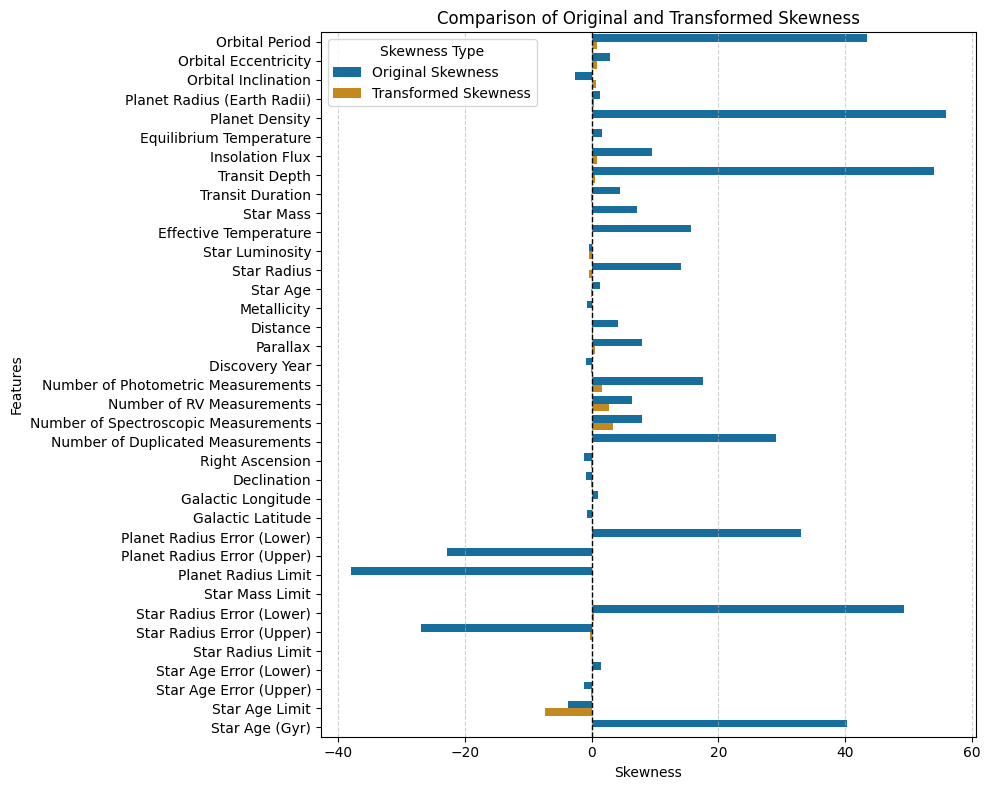

In [18]:
# Plot comparison
skewness_long = skewness_comparison.melt(id_vars='Feature', value_vars=['Original Skewness', 'Transformed Skewness'],
                                          var_name='Type', value_name='Skewness')

plt.figure(figsize=(10, 8))
sns.barplot(data=skewness_long, x='Skewness', y='Feature', hue='Type', 
            palette='colorblind',
            #palette={'Original Skewness': 'lightblue', 'Transformed Skewness': 'lightcoral'},
            dodge=True)
plt.axvline(0, color='black', linewidth=1, linestyle='--')
plt.title('Comparison of Original and Transformed Skewness')
plt.xlabel('Skewness')
plt.ylabel('Features')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.legend(title='Skewness Type')
plt.tight_layout()
plt.show()


In [12]:
# Save the transformed DataFrame
transformed_data.to_csv('Exoplanet_Data_Transformed.csv', index=False)
print("Transformed DataFrame saved as 'Exoplanet_Data_Transformed.csv'")


Transformed DataFrame saved as 'Exoplanet_Data_Transformed.csv'
